In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from tacrypto import talibCrypto

import time

In [2]:
from sklearn.metrics import precision_score, accuracy_score

In [3]:
minute_data_cols = ['open', 'high', 'low', 'close', 'volume', 'time']
binance_swap_min_BTCUSDT = pd.read_csv('binance_swap_kline.BTCUSDT.csv')
binance_swap_min_BTCUSDT['t'] = pd.to_datetime(binance_swap_min_BTCUSDT['t'], unit='ms')
binance_swap_min_BTCUSDT.columns = minute_data_cols
binance_swap_min_BTCUSDT.set_index('time', inplace=True)

binance_swap_min_BTCUSDT = binance_swap_min_BTCUSDT.loc["2019-09-09 02:51:00":]

binance_swap_min_BTCUSDT = binance_swap_min_BTCUSDT.groupby(binance_swap_min_BTCUSDT.index).last()

binance_swap_min_BTCUSDT['avg_price'] = (binance_swap_min_BTCUSDT['close'] + binance_swap_min_BTCUSDT['high'] + binance_swap_min_BTCUSDT['low']) / 3

In [4]:
binance_swap_min_BTCUSDT

,open,high,low,close,volume,avg_price
time,,,,,,
2019-09-09 02:51:00,10316.62,10316.62,10316.62,10316.62,4.421,10316.620000
2019-09-09 02:52:00,10316.62,10316.65,10316.29,10316.63,11.954,10316.523333
2019-09-09 02:53:00,10316.63,10316.63,10315.14,10316.18,12.773,10315.983333
2019-09-09 02:54:00,10316.18,10316.18,10314.14,10314.14,9.889,10314.820000
2019-09-09 02:55:00,10316.14,10316.30,10315.47,10316.26,10.601,10316.010000
...,...,...,...,...,...,...
2020-12-06 15:55:00,19108.96,19140.00,19108.00,19133.35,88.668,19127.116667
2020-12-06 15:56:00,19133.35,19138.97,19126.07,19129.59,59.505,19131.543333
2020-12-06 15:57:00,19129.59,19129.59,19111.78,19122.55,102.481,19121.306667


In [5]:
tacry = talibCrypto(binance_swap_min_BTCUSDT)

In [6]:
start = time.time()
taSeriesList = []
for i in range(len(tacry.talib_function)):
    taSeriesList.append(tacry.talib_function[i]())
end = time.time()
print("Runtime: {}".format(end - start))

Runtime: 1.321202039718628


In [7]:
interval= 5
return_pd_series = binance_swap_min_BTCUSDT['avg_price'].pct_change(periods=interval).shift(-interval)
return_pd_series.name = '5min_return'

In [8]:
taSeriesList.append(return_pd_series)

In [9]:
ta_df = pd.concat(taSeriesList, axis=1).astype('float32')

In [10]:
ta_df.dropna(inplace=True)

In [207]:
ta_df['label'] = (ta_df['5min_return'] - ta_df['5min_return'].min()) / (ta_df['5min_return'].max() - ta_df['5min_return'].min())

In [208]:
ta_train_df = ta_df.loc["2019-09-09":"2020-08-05"]
ta_val_df = ta_df.loc["2020-08-06":"2020-10-06"]
ta_test_df = ta_df.loc["2020-10-06":]

In [209]:
feature_num = len(tacry.talib_function)
print(feature_num)

43


In [211]:
train_X = ta_train_df.iloc[:, :feature_num].values
train_Y = ta_train_df['label'].values

val_X = ta_val_df.iloc[:, :feature_num].values
val_Y = ta_val_df['label'].values

test_X = ta_test_df.iloc[:, :feature_num].values
test_Y = ta_test_df['label'].values

In [212]:
import xgboost as xgb

In [213]:
def huber_approx_obj(preds, dtrain):
    d = preds - dtrain.get_label()
    h = 1  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

In [214]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_X)
val_features = scaler.transform(val_X)
test_features = scaler.transform(test_X)

Dtrain = xgb.DMatrix(data=train_features, label=train_Y)
Dval = xgb.DMatrix(data=val_features, label=val_Y)
Dtest = xgb.DMatrix(data=test_features, label=test_Y)

# Dtrain = xgb.DMatrix(data=train_X, label=train_Y)
# Dval = xgb.DMatrix(data=val_X, label=val_Y)
# Dtest = xgb.DMatrix(data=test_X, label=test_Y)

In [217]:
params = {
    'booster': 'gbtree',
    'eta': 0.3,
    'gamma': 0,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'lambda': 40,
    'alpha': 10,
    'tree_method': 'gpu_hist',
    'eval_metric': ['mae'],
    'seed': 0
}

evals = {}
booster = xgb.train(
    params=params, 
    dtrain=Dtrain, evals=[(Dtrain, 'Train'), (Dval, 'Valid')],
    num_boost_round=100,
    verbose_eval=False,
    early_stopping_rounds=10,
    evals_result=evals,
    obj=huber_approx_obj
)

print(evals['Valid']['mae'][-1])
print(booster.eval(Dtest))

0.003149
[0]	eval-mae:0.004287


In [193]:
# ta_df.corr().astype("float32").to_csv('corr.csv')

In [218]:
val_pred_Y = booster.predict(Dval)

In [221]:
val_pred_Y.min()

0.4278537

In [222]:
# train_pred_y = booster.predict(Dtrain)
# scale_num = np.mean(train_Y / train_pred_y)
# print(scale_num)

# adjust_val_pred_Y = val_pred_Y * scale_num
adjust_val_pred_Y = (val_pred_Y - val_pred_Y.min()) / (val_pred_Y.max() - val_pred_Y.min())

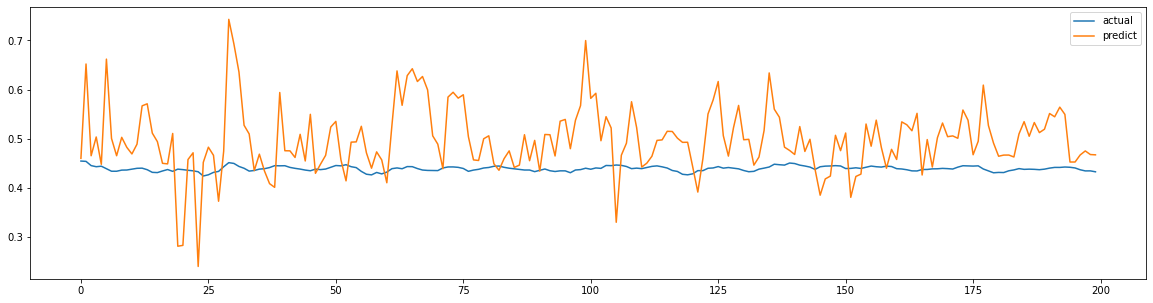

In [223]:
plt.figure(figsize=(20, 5))
plt.plot(val_Y[:200], label='actual')
plt.plot(adjust_val_pred_Y[:200], label='predict')
plt.legend()

In [179]:
def action_transform(x):
    if x > 0.001:
        return 1
    elif x < -0.001:
        return -1
    else:
        return 0

In [180]:
val_true_action = list(map(action_transform, val_Y))
val_pred_action = list(map(action_transform, adjust_val_pred_Y))

In [181]:
(np.array(val_pred_action) == np.array(val_true_action)).sum() / len(val_true_action)

0.39404121863799285

In [182]:
actual_long = np.count_nonzero(np.array(val_true_action) == 1)
actual_short = np.count_nonzero(np.array(val_true_action) == -1)
actual_close = np.count_nonzero(np.array(val_true_action) == 0)

In [183]:
pred_long = 0
pred_short = 0
pred_close = 0
for i in range(len(val_true_action)):
    if val_true_action[i] == 1 and val_pred_action[i] == 1:
        pred_long += 1
    elif val_true_action[i] == -1 and val_pred_action[i] == -1:
        pred_short += 1
    elif val_true_action[i] == 0 and val_pred_action[i] == 0:
        pred_close += 1

print(pred_long / actual_long)
print(pred_short / actual_short)
print(pred_close / actual_close)

0.4088835713751589
0.43295946045011363
0.3823274339125687
